In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(97)

In [2]:
saved_models_dir = "/global/scratch/users/aniketh/promoter_modelling/jax_data/saved_DEN_models_v13_TITAN/"
jax_data_dir = "/global/scratch/users/aniketh/promoter_modelling/jax_data/"
expression_percentile_filter_thres = 90

In [3]:
len(os.listdir(saved_models_dir))

54

In [4]:
all_configs = []
all_configs.append({
    "diversity_loss_coef": 1.0,
    "entropy_loss_coef": 1.0,
    "base_entropy_loss_coef": 5.0,
})
all_configs.append({
    "diversity_loss_coef": 5.0,
    "entropy_loss_coef": 1.0,
    "base_entropy_loss_coef": 5.0,
})
all_configs.append({
    "diversity_loss_coef": 10.0,
    "entropy_loss_coef": 1.0,
    "base_entropy_loss_coef": 10.0,
})

In [5]:
all_predicted_exps = {}
all_predicted_exps["designed_for"] = []
all_predicted_exps["sequence"] = []
all_predicted_exps["design_model"] = []
all_predicted_exps["diversity_loss_coef"] = []
all_predicted_exps["entropy_loss_coef"] = []
all_predicted_exps["base_entropy_loss_coef"] = []

for cell in ["THP1", "Jurkat", "K562"]:
    all_predicted_exps[cell] = []

for model in sorted(os.listdir(os.path.join(jax_data_dir, "trained_predictors_final"))):
    for diff_exp_cell_ind, cell in enumerate(["THP1", "Jurkat", "K562"]):
        for config in all_configs:
            diversity_loss_coef = config["diversity_loss_coef"]
            entropy_loss_coef = config["entropy_loss_coef"]
            base_entropy_loss_coef = config["base_entropy_loss_coef"]

            experiment_id = f"{cell}_using_{model}_div_coef_{diversity_loss_coef}_ent_coef_{entropy_loss_coef}_bent_coef_{base_entropy_loss_coef}"
            
            print(experiment_id)
            
            try:
                assert os.path.exists(os.path.join(saved_models_dir, experiment_id, "final_sequences.npy"))
                assert os.path.exists(os.path.join(saved_models_dir, experiment_id, "final_sequences_predicted_exps.npy"))
            except:
                assert os.path.exists(os.path.join(saved_models_dir, experiment_id, "OPTIMIZATION_FAILED.txt"))
                print("No results found")
                continue
            
            final_sequences_predicted_exps = np.load(os.path.join(saved_models_dir, experiment_id, "final_sequences_predicted_exps.npy"))
            
            final_sequences = np.load(os.path.join(saved_models_dir, experiment_id, "final_sequences.npy"))
            final_sequences = np.argmax(final_sequences, axis=-1)
            final_sequences = np.vectorize({0: 'A', 1: 'C', 2: 'G', 3: 'T'}.get)(final_sequences)
            
            # first filter out sequences that have no differential expression
            filter_out = np.array([False for i in range(len(final_sequences))])
            for i, exp_cell in enumerate(["THP1", "Jurkat", "K562"]):
                if i == diff_exp_cell_ind:
                    continue
                filter_out = np.logical_or(filter_out, 
                                           final_sequences_predicted_exps[:, diff_exp_cell_ind] < final_sequences_predicted_exps[:, i])
            print(f"{np.sum(filter_out)} lack differential expression and are being filtered out")
            if np.sum(filter_out) == len(final_sequences):
                print("OPTIMIZATION FAILED, no sequences with differential expression")
                continue
            final_sequences = final_sequences[~filter_out]
            final_sequences_predicted_exps = final_sequences_predicted_exps[~filter_out]
            assert final_sequences_predicted_exps.shape[0] == final_sequences.shape[0]
            for i, exp_cell in enumerate(["THP1", "Jurkat", "K562"]):
                if i == diff_exp_cell_ind:
                    continue
                assert np.sum(final_sequences_predicted_exps[:, diff_exp_cell_ind] < final_sequences_predicted_exps[:, i]) == 0
            print(f"Left with {len(final_sequences)} sequences")
            
            # filter out sequences with low predicted expression when compared to the test set predictions
            test_set_preds = np.load(os.path.join(saved_models_dir, experiment_id, "all_yhat.npy"), allow_pickle=True)[()]
            percentile_thres = np.percentile(test_set_preds[cell], expression_percentile_filter_thres)
            print(f"{expression_percentile_filter_thres}th percentile test set expression threshold = {percentile_thres}")
            filter_out = final_sequences_predicted_exps[:, diff_exp_cell_ind] < percentile_thres
            print(f"{np.sum(filter_out)} have low predicted expression and are being filtered out")
            if np.sum(filter_out) == len(final_sequences):
                print("OPTIMIZATION FAILED, no sequences with differential expression")
                continue
            final_sequences = final_sequences[~filter_out]
            final_sequences_predicted_exps = final_sequences_predicted_exps[~filter_out]
            assert final_sequences_predicted_exps.shape[0] == final_sequences.shape[0]
            for i, exp_cell in enumerate(["THP1", "Jurkat", "K562"]):
                if i == diff_exp_cell_ind:
                    continue
                assert np.sum(final_sequences_predicted_exps[:, diff_exp_cell_ind] < final_sequences_predicted_exps[:, i]) == 0
            print(f"Left with {len(final_sequences)} sequences")
            
            
            all_predicted_exps["designed_for"].extend([cell]*len(final_sequences_predicted_exps))
            all_predicted_exps["sequence"].extend(final_sequences)
            all_predicted_exps["design_model"].extend([model]*len(final_sequences_predicted_exps))
            all_predicted_exps["diversity_loss_coef"].extend([diversity_loss_coef]*len(final_sequences_predicted_exps))
            all_predicted_exps["entropy_loss_coef"].extend([entropy_loss_coef]*len(final_sequences_predicted_exps))
            all_predicted_exps["base_entropy_loss_coef"].extend([base_entropy_loss_coef]*len(final_sequences_predicted_exps))
            
            for i, exp_cell in enumerate(["THP1", "Jurkat", "K562"]):
                all_predicted_exps[exp_cell].extend(final_sequences_predicted_exps[:, i])
            
            print()
                
all_predicted_exps = pd.DataFrame(all_predicted_exps)

THP1_using_coms_0.0003_THP1_weight_1.5.pkl_div_coef_1.0_ent_coef_1.0_bent_coef_5.0
0 lack differential expression and are being filtered out
Left with 5000 sequences
90th percentile test set expression threshold = 1.4059834241867089
3976 have low predicted expression and are being filtered out
Left with 1024 sequences

THP1_using_coms_0.0003_THP1_weight_1.5.pkl_div_coef_5.0_ent_coef_1.0_bent_coef_5.0
83 lack differential expression and are being filtered out
Left with 4917 sequences
90th percentile test set expression threshold = 1.4059830307960532
3680 have low predicted expression and are being filtered out
Left with 1237 sequences

THP1_using_coms_0.0003_THP1_weight_1.5.pkl_div_coef_10.0_ent_coef_1.0_bent_coef_10.0
932 lack differential expression and are being filtered out
Left with 4068 sequences
90th percentile test set expression threshold = 1.4059834241867089
4024 have low predicted expression and are being filtered out
Left with 44 sequences

Jurkat_using_coms_0.0003_THP1_weig

1 lack differential expression and are being filtered out
Left with 4999 sequences
90th percentile test set expression threshold = 2.274063587188721
4997 have low predicted expression and are being filtered out
Left with 2 sequences

K562_using_coms_0.003_THP1_weight_1.5.pkl_div_coef_10.0_ent_coef_1.0_bent_coef_10.0
0 lack differential expression and are being filtered out
Left with 5000 sequences
90th percentile test set expression threshold = 2.274063587188721
5000 have low predicted expression and are being filtered out
OPTIMIZATION FAILED, no sequences with differential expression
THP1_using_coms_0.01_THP1_weight_1.5.pkl_div_coef_1.0_ent_coef_1.0_bent_coef_5.0
0 lack differential expression and are being filtered out
Left with 5000 sequences
90th percentile test set expression threshold = 1.431400156021119
5000 have low predicted expression and are being filtered out
OPTIMIZATION FAILED, no sequences with differential expression
THP1_using_coms_0.01_THP1_weight_1.5.pkl_div_coef_5.0

0 lack differential expression and are being filtered out
Left with 5000 sequences
90th percentile test set expression threshold = 2.2560388565063483
0 have low predicted expression and are being filtered out
Left with 5000 sequences

K562_using_coms_0.0_THP1_weight_1.5.pkl_div_coef_5.0_ent_coef_1.0_bent_coef_5.0
0 lack differential expression and are being filtered out
Left with 5000 sequences
90th percentile test set expression threshold = 2.2560388565063483
747 have low predicted expression and are being filtered out
Left with 4253 sequences

K562_using_coms_0.0_THP1_weight_1.5.pkl_div_coef_10.0_ent_coef_1.0_bent_coef_10.0
0 lack differential expression and are being filtered out
Left with 5000 sequences
90th percentile test set expression threshold = 2.2560388565063483
4945 have low predicted expression and are being filtered out
Left with 55 sequences



In [6]:
all_predicted_exps["sequence"] = all_predicted_exps.apply(lambda x: "".join(x["sequence"]), axis=1)

THP1


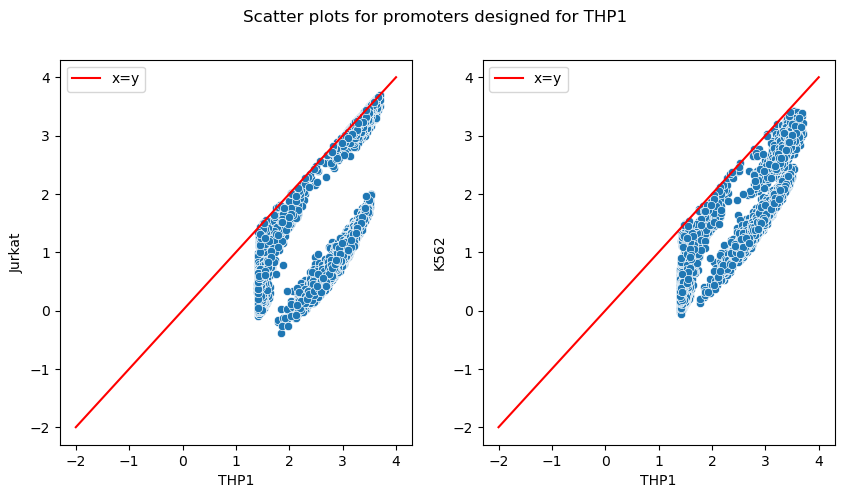

Jurkat


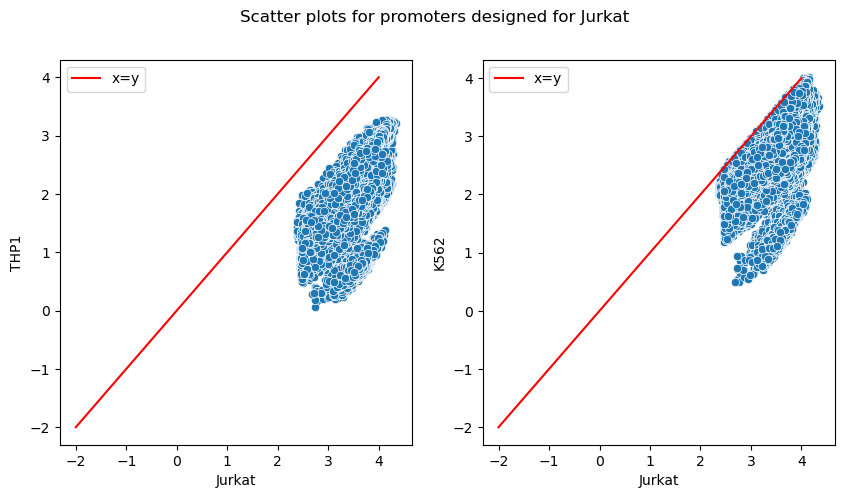

K562


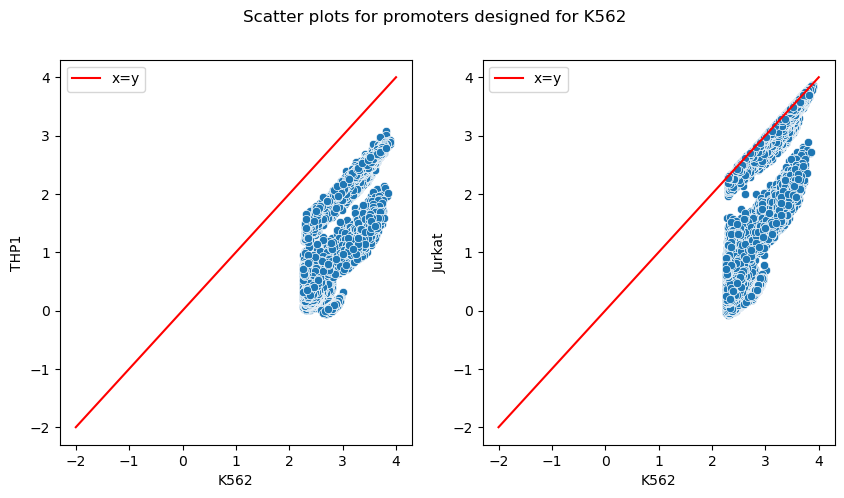

In [7]:
for cell in ["THP1", "Jurkat", "K562"]:
    print(cell)
    other_cells = [c for c in ["THP1", "Jurkat", "K562"] if c != cell]
    
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    
    for j, other_cell in enumerate(other_cells):
        sns.scatterplot(data=all_predicted_exps[all_predicted_exps["designed_for"] == cell].reset_index(drop=True), \
                        x=cell,
                        y=other_cell, \
                        ax=ax[j])
        ax[j].plot(np.linspace(-2, 4, 10), np.linspace(-2, 4, 10), color="r", label="x=y")
        ax[j].legend()
    fig.suptitle(f"Scatter plots for promoters designed for {cell}")
    plt.show()

In [8]:
# for cell in ["THP1", "Jurkat", "K562"]:
cell = "THP1"
print(cell)
other_cells = [c for c in ["THP1", "Jurkat", "K562"] if c != cell]

seqs_designed_for_cell = all_predicted_exps[all_predicted_exps["designed_for"] == cell].reset_index(drop=True)
seqs_designed_for_cell["max_diff"] = seqs_designed_for_cell[cell] - np.max(seqs_designed_for_cell[other_cells], axis=1)
seqs_designed_for_cell = seqs_designed_for_cell.sort_values(by="max_diff", ascending=False)

THP1


In [9]:
seqs_designed_for_cell

,designed_for,sequence,design_model,diversity_loss_coef,entropy_loss_coef,base_entropy_loss_coef,THP1,Jurkat,K562,max_diff
3439,THP1,CGACGTCCCAACATGTCCGAACATGAAGCCTCCCTTTTTCTCTGGA...,coms_0.0_THP1_weight_1.5.pkl,1.0,1.0,5.0,2.226830,0.027735,0.522083,1.704746
6228,THP1,CGACGTCCCAACATGTCCGAACATGAAGCCTCTCTTTTTCTCAGGA...,coms_0.0_THP1_weight_1.5.pkl,1.0,1.0,5.0,2.054682,-0.087931,0.375960,1.678722
4668,THP1,CGACGTCCCAACATGTCCGAACATGAAGCCTCTTTTTTTCTCAGGA...,coms_0.0_THP1_weight_1.5.pkl,1.0,1.0,5.0,2.331892,0.072519,0.660935,1.670957
4330,THP1,CGACGTCCCAACATGTCCGAACATGAAGCCTCCTTTTTTCTCAGGA...,coms_0.0_THP1_weight_1.5.pkl,1.0,1.0,5.0,2.529482,0.262683,0.863946,1.665535
5043,THP1,CGACGTCCCAACATGTCCGAACATGAAGCCTCCTTTTTTCTCAGGA...,coms_0.0_THP1_weight_1.5.pkl,1.0,1.0,5.0,2.274224,0.037540,0.609186,1.665038
...,...,...,...,...,...,...,...,...,...,...
7979,THP1,CGCCGCGGCGGCCGCCGCGCGGCGGCGCGCGGCGCGCGGCGCGGCG...,coms_0.0_THP1_weight_1.5.pkl,5.0,1.0,5.0,3.500995,3.500545,2.980897,0.000450
8402,THP1,CGCCGCCATCTTCCCCGCGGCGGCGCGGCGGCGGGGGCGACGTCGC...,coms_0.0_THP1_weight_1.5.pkl,5.0,1.0,5.0,3.478131,3.477692,3.004758,0.000439
2312,THP1,GCGGCCGCCGCGGCGGCGGCCGCCGCGGCGGCGGCCGCCGCCGCCG...,coms_0.001_THP1_weight_1.5.pkl,5.0,1.0,5.0,3.612922,3.612513,3.212720,0.000409
9621,THP1,CGCCGCCGGCCGGCCGCGGCCGGCGGCGGCGGCGGCCGCGCCGGCG...,coms_0.0_THP1_weight_1.5.pkl,10.0,1.0,10.0,3.406831,3.406466,2.702228,0.000365


In [10]:
all_predicted_exps.to_parquet(os.path.join(jax_data_dir, "final_sequences_v13.parquet"), index=False)

In [11]:
all_predicted_exps

,designed_for,sequence,design_model,diversity_loss_coef,entropy_loss_coef,base_entropy_loss_coef,THP1,Jurkat,K562
0,THP1,AACAAATTTTAATATACTACAGCTTCGGCCTTGCTTTTTTTTTTTT...,coms_0.0003_THP1_weight_1.5.pkl,1.0,1.0,5.0,1.448439,0.024380,0.161597
1,THP1,AACAAATTTTAATATACTACAGCTTCGGCCTTGCATTTTTTTTTTT...,coms_0.0003_THP1_weight_1.5.pkl,1.0,1.0,5.0,1.485409,0.107551,0.177417
2,THP1,AACAAATTTTAATATACTACAGCTTCGGCCTTGCATTTTTTTTTTT...,coms_0.0003_THP1_weight_1.5.pkl,1.0,1.0,5.0,1.546922,0.152277,0.298792
3,THP1,AACAAATTTTAATATACTACAGCTTCGGCCTTGCTTTTTTTTTTTT...,coms_0.0003_THP1_weight_1.5.pkl,1.0,1.0,5.0,1.510596,0.131218,0.211093
4,THP1,AACAAATTTTAATATACTACAGCTTCGGCCTTGCATTTTTTTTTTT...,coms_0.0003_THP1_weight_1.5.pkl,1.0,1.0,5.0,1.410489,0.054258,0.064643
...,...,...,...,...,...,...,...,...,...
117498,K562,ACAAAAAACCAAAAAAGACCCCCAAAAAGCCCGCCCAACAAAAACG...,coms_0.0_THP1_weight_1.5.pkl,10.0,1.0,10.0,0.650327,0.617467,2.265131
117499,K562,AAACAACAAACACCAACACCAAAACCAAACCCCACCAAAAAAAAAA...,coms_0.0_THP1_weight_1.5.pkl,10.0,1.0,10.0,0.738011,0.683169,2.271510
117500,K562,AAAAAACAGCCCCAAAAACAAACACAAAAAAAAAACAACCCCGAAA...,coms_0.0_THP1_weight_1.5.pkl,10.0,1.0,10.0,0.819458,0.780028,2.358301
117501,K562,CACCCCCACACCCAAACCGAAACCACCACCCAAAAACCCCCCACAA...,coms_0.0_THP1_weight_1.5.pkl,10.0,1.0,10.0,0.627865,0.632838,2.284508


<Axes: xlabel='designed_for', ylabel='count'>

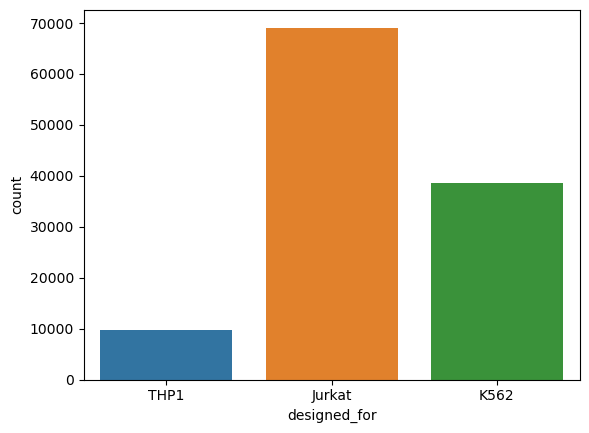

In [12]:
sns.countplot(data=all_predicted_exps, x="designed_for")

<Axes: xlabel='design_model', ylabel='count'>

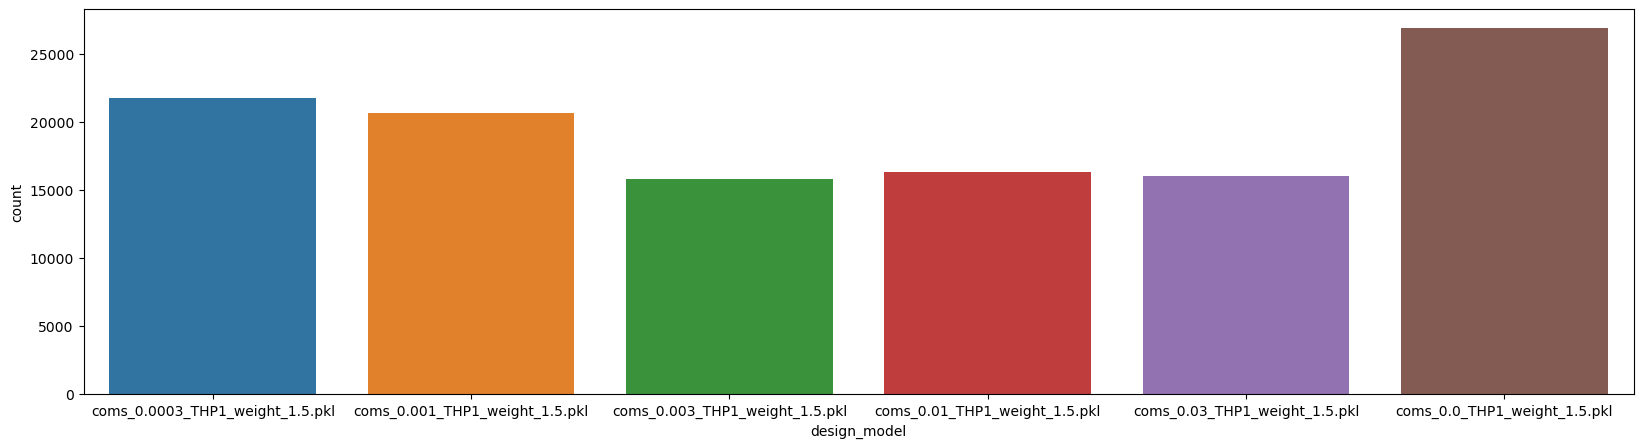

In [13]:
plt.figure(figsize=(20, 5))
sns.countplot(data=all_predicted_exps, x="design_model")

<Axes: xlabel='diversity_loss_coef', ylabel='count'>

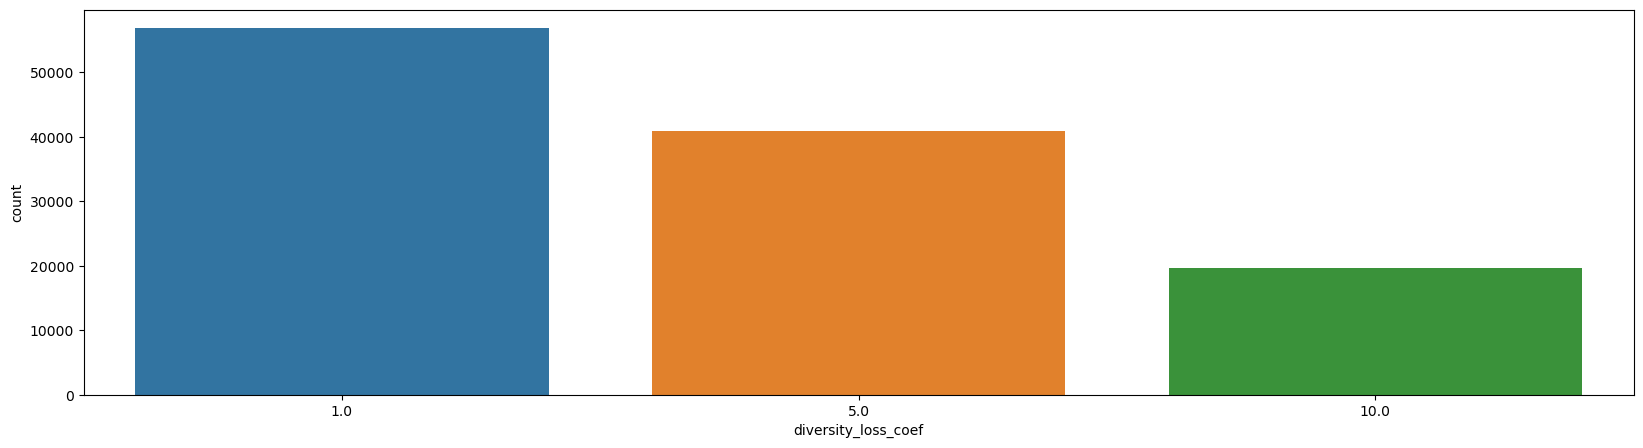

In [14]:
plt.figure(figsize=(20, 5))
sns.countplot(data=all_predicted_exps, x="diversity_loss_coef")